In [1]:
# Paquetes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from scipy.integrate import solve_ivp

In [2]:
def angle_of_vectors(a,b):
    cosTh = np.dot(a,b)
    sinTh = np.cross(a,b)
    # Ángulo
    theta = np.arctan2(sinTh,cosTh)
    return theta

def L_sigma(P, sigma, verbose=False):
    r = P.reshape(-1,2).sum(axis=0) / (P.shape[0] / 2)
    grad = sum([sigma(pi[0], pi[1])*(pi - r) for pi in P.reshape(-1,2)]) 
    grad /= np.linalg.norm(grad)
    return -grad

    
def r(Fdeq, X_0, t0, tf, Npoints=None):
    """
    Devuelve la función r(t) solución del problema anterior. Donde
        - X_0: Es el vector de condiciones iniciales
        - Fdeq: Parte derecha de la eq differencial  
        - t0: Tiempo inicial. 
        - tf: Tiempo final.
        - Npoints: Número de puntos de para calcular r(t) si no le damos ninguno
                    cálcula como np.abs(tf-t0)*10
    """
    Npoints = np.abs(tf-t0)*10 if Npoints is None else Npoints
    t_eval = t_eval=np.linspace(t0,tf,Npoints)
    
    # Devolvemos la solución del problema
    # solve_ivp hace algo parecido a ode45 en Matlab
    return solve_ivp(Fdeq, (t0, tf), X_0, t_eval=t_eval)

## Creation of the robot array and parameters:

We first input the information about the robot array, the scalar field and create the robot array:

In [3]:
# Parameters to modify:
# Function to find local minima:
sigma = lambda x, y: -10*(np.exp((-x**2-y**2)/100)) # Función a optimizar
# sigma = lambda x,y: (x**2 + 3*x**2 * y**2 - x*y + 8*y**2)

N = 6 # Number of robots
K = 1 # Control the angular speed of the robots
r_c0 = np.array([7, -12]) # Center of the initial array

# Indica si queremos información del gradiente
verbose=True

D_mean = 1 # Mean distance to the center
desv = D_mean/2 # Standart deviation to the mean
desv_ang = np.pi/4 # Standart deviation to the angles - when creating robot array
des_vel = np.pi # Standart deviation of the original velocities

# Distances to the origin
D = []
for i in range(N):
    phi = np.random.normal(loc=0, scale=desv_ang, size=None) + 2*np.pi * i / N # Elegimos el ángulo rotado respecto al centro del círculo
    D_random = np.random.normal(loc=D_mean, scale=desv, size=None) # Calculamos el radio de este robot
    D.append(D_random*np.array([np.cos(phi), np.sin(phi)]))
            
# Ajustamos los D para que sum_i=1^N valga 0, es decir, le quitamos la media
D = [di - np.array(D).sum(axis=0) / N for di in D]

Now, we solve the differential equation given by our method.

In [4]:
# Calculamos L
L = lambda P: L_sigma(P, sigma)


# Vector of initial conditions
P_0 = (np.array(D) + r_c0).flatten()
angle_0 = np.random.normal(loc=0, scale=des_vel, size=(N,)) % np.pi
X_0 = np.concatenate((P_0, angle_0))

# Differential equation to solve F(t, r(t))
def F(t, X):
    Y = np.zeros((3*N,))
    Lt = L(X[:2*N])
    for i, angle in enumerate(X[2*N:]):
        vel = np.array([np.cos(angle),np.sin(angle)])
        Y[(2*i):(2*i+2)] = vel
        Y[2*N+i] = -K*angle_of_vectors(Lt, vel)

    return Y


# Solution to the problem
sol = r(F, X_0, t0=0, tf=50)
t = sol.t

x = sol.y[:2*N:2]
y = sol.y[1:2*N:2]
angles = sol.y[2*N:]

Finally, we can plot the solutions:

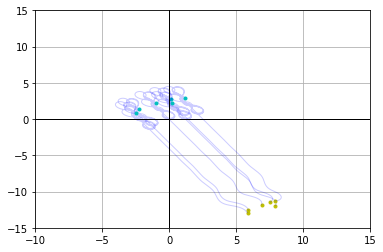

In [5]:
# Ploteamos la trayectoria de los robots
for rx, ry in zip(x, y):
    plt.plot(rx[0], ry[0], 'yo', markersize=3)
    plt.plot(rx, ry,'b', alpha=0.2, linewidth=1)
    plt.plot(rx[-1], ry[-1], 'co', markersize=3)

# Ajustamos los ejes
plt.xlim([-10, 15])
plt.ylim([-15, 15])

# Ajustamos el grid y los hacemos display de los ejes
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linewidth=1)
plt.axvline(x=0, color='k', linewidth=1)